In [1]:
!pip install ultralytics -q
!pip install scikit-learn matplotlib opencv-python pyyaml tqdm -q
!pip install seaborn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.2 MB/s eta 0:00:00:00:0100:01


In [2]:
import os
import cv2
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image, ImageDraw
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import shutil
from pathlib import Path
import torch
from ultralytics import YOLO
import random


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12, 8)

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("Sử dụng CPU cho training")

CUDA available: True
GPU: Tesla P100-PCIE-16GB
CUDA version: 12.4


In [14]:
# Establish working directories (compatible with local and Kaggle environments)
BASE_DIR = Path.cwd().resolve()
print(f"Working directory: {BASE_DIR}")

DATA_DIR = Path("/kaggle/input/waste2/data").resolve()
RUNS_DIR = BASE_DIR / "runs"
RUNS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Runs directory: {RUNS_DIR}")


Working directory: /kaggle/working
Data directory: /kaggle/input/waste2/data
Runs directory: /kaggle/working/runs


In [16]:
# Dataset paths and experiment configuration
DATA_CONFIG = (DATA_DIR / "data.yaml").resolve()

TRAIN_IMG_DIR = DATA_DIR / "train" / "images"
TRAIN_LABEL_DIR = DATA_DIR / "train" / "labels"
VALID_IMG_DIR = DATA_DIR / "val" / "images"
VALID_LABEL_DIR = DATA_DIR / "val" / "labels"
TEST_IMG_DIR = DATA_DIR / "test" / "images"
TEST_LABEL_DIR = DATA_DIR / "test" / "labels"

PATHS_TO_CHECK = {
    "train_images": TRAIN_IMG_DIR,
    "train_labels": TRAIN_LABEL_DIR,
    "valid_images": VALID_IMG_DIR,
    "valid_labels": VALID_LABEL_DIR,
    "test_images": TEST_IMG_DIR,
    "test_labels": TEST_LABEL_DIR,
    "data_yaml": DATA_CONFIG,
}

for name, path in PATHS_TO_CHECK.items():
    if not path.exists():
        print(f"Warning: {name} not found at {path}")

CLASS_NAMES = []
if DATA_CONFIG.exists():
    with open(DATA_CONFIG, "r", encoding="utf-8") as f:
        data_yaml = yaml.safe_load(f) or {}
        names = data_yaml.get("names")
        if isinstance(names, dict):
            CLASS_NAMES = [names[k] for k in sorted(names.keys())]
        elif isinstance(names, list):
            CLASS_NAMES = names

if not CLASS_NAMES:
    CLASS_NAMES = [f"class_{idx}" for idx in range(4)]

print(f"Classes: {CLASS_NAMES}")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

WORKERS = min(8, os.cpu_count() or 1)
BATCH_SIZE = -1 #auto batch size 
EPOCHS = 50
RUN_NAME = "garbage_detect"

Classes: ['glass', 'metal', 'paper', 'plastic']


In [20]:
# Kiểm tra số lượng ảnh trong mỗi tập
def count_images(img_dir):
    return len([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])

train_count = count_images(TRAIN_IMG_DIR)
valid_count = count_images(VALID_IMG_DIR)
test_count = count_images(TEST_IMG_DIR)
total_count = train_count + valid_count + test_count

print(f"\n=== THỐNG KÊ SỐ LƯỢNG ẢNH ===")
print(f"Train: {train_count} ảnh ({train_count/total_count:.1%})")
print(f"Valid: {valid_count} ảnh ({valid_count/total_count:.1%})")
print(f"Test: {test_count} ảnh ({test_count/total_count:.1%})")
print(f"Tổng: {total_count} ảnh")


=== THỐNG KÊ SỐ LƯỢNG ẢNH ===
Train: 4361 ảnh (71.1%)
Valid: 1159 ảnh (18.9%)
Test: 610 ảnh (10.0%)
Tổng: 6130 ảnh


In [21]:
# Utilities for visualising samples
from itertools import cycle

def visualize_samples(img_dir: Path, label_dir: Path, class_names, num_samples=6, title="Samples"):
    if not img_dir.exists():
        print(f"No images found in {img_dir}")
        return

    image_files = [p for p in img_dir.iterdir() if p.suffix.lower() in {".jpg", ".jpeg", ".png"}]
    if not image_files:
        print(f"No images found in {img_dir}")
        return

    samples = random.sample(image_files, min(num_samples, len(image_files)))
    cols = 3
    rows = (len(samples) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    colour_cycle = cycle(["red", "blue", "green", "orange", "purple", "cyan"])

    for ax, image_path in zip(axes, samples):
        image = Image.open(image_path)
        img_width, img_height = image.size
        ax.imshow(image)
        ax.set_title(f"{title}: {image_path.name[:30]}", fontsize=10)
        ax.axis("off")

        label_path = label_dir / (image_path.stem + ".txt")
        if not label_path.exists():
            continue

        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                class_id = int(float(parts[0]))
                x_center, y_center, width, height = map(float, parts[1:5])
                x_min = int((x_center - width / 2) * img_width)
                y_min = int((y_center - height / 2) * img_height)
                box_width = int(width * img_width)
                box_height = int(height * img_height)
                colour = next(colour_cycle)
                rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=2, edgecolor=colour, facecolor='none')
                ax.add_patch(rect)
                class_name = class_names[class_id] if class_id < len(class_names) else f"class_{class_id}"
                ax.text(x_min, max(y_min - 5, 0), class_name, color='white', backgroundcolor=colour, fontsize=8)

    # Hide any unused axes
    for ax in axes[len(samples):]:
        ax.axis("off")

    plt.tight_layout()


=== TRAIN SAMPLES ===


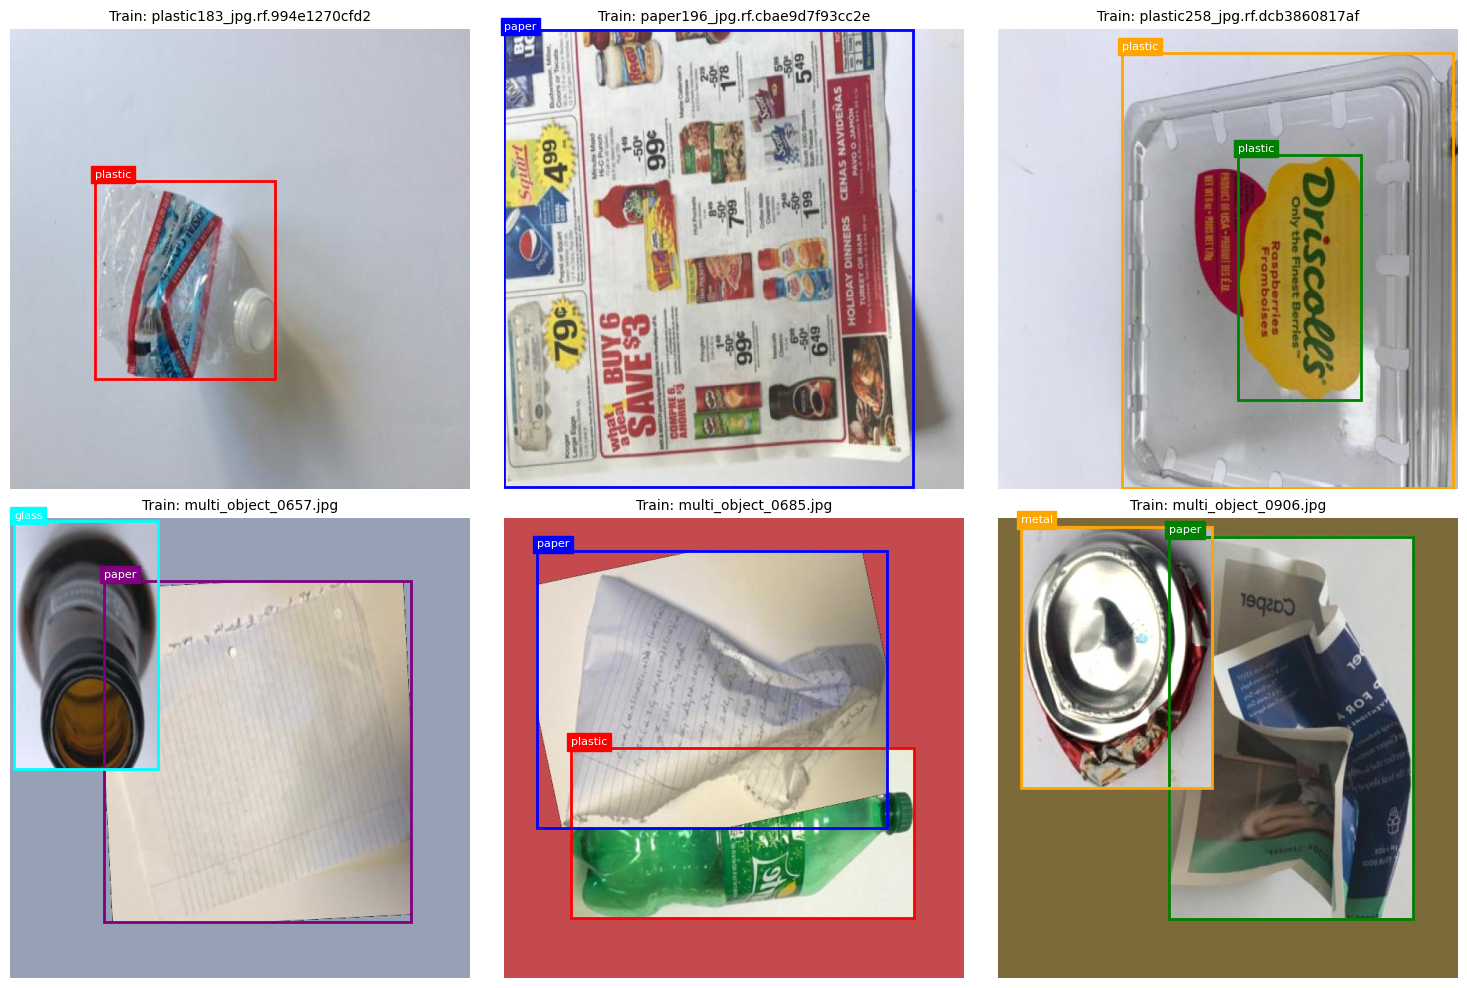

In [23]:
# Sample visuals from the train split
print("=== TRAIN SAMPLES ===")
visualize_samples(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, CLASS_NAMES, num_samples=6, title="Train")


=== VALIDATION SAMPLES ===


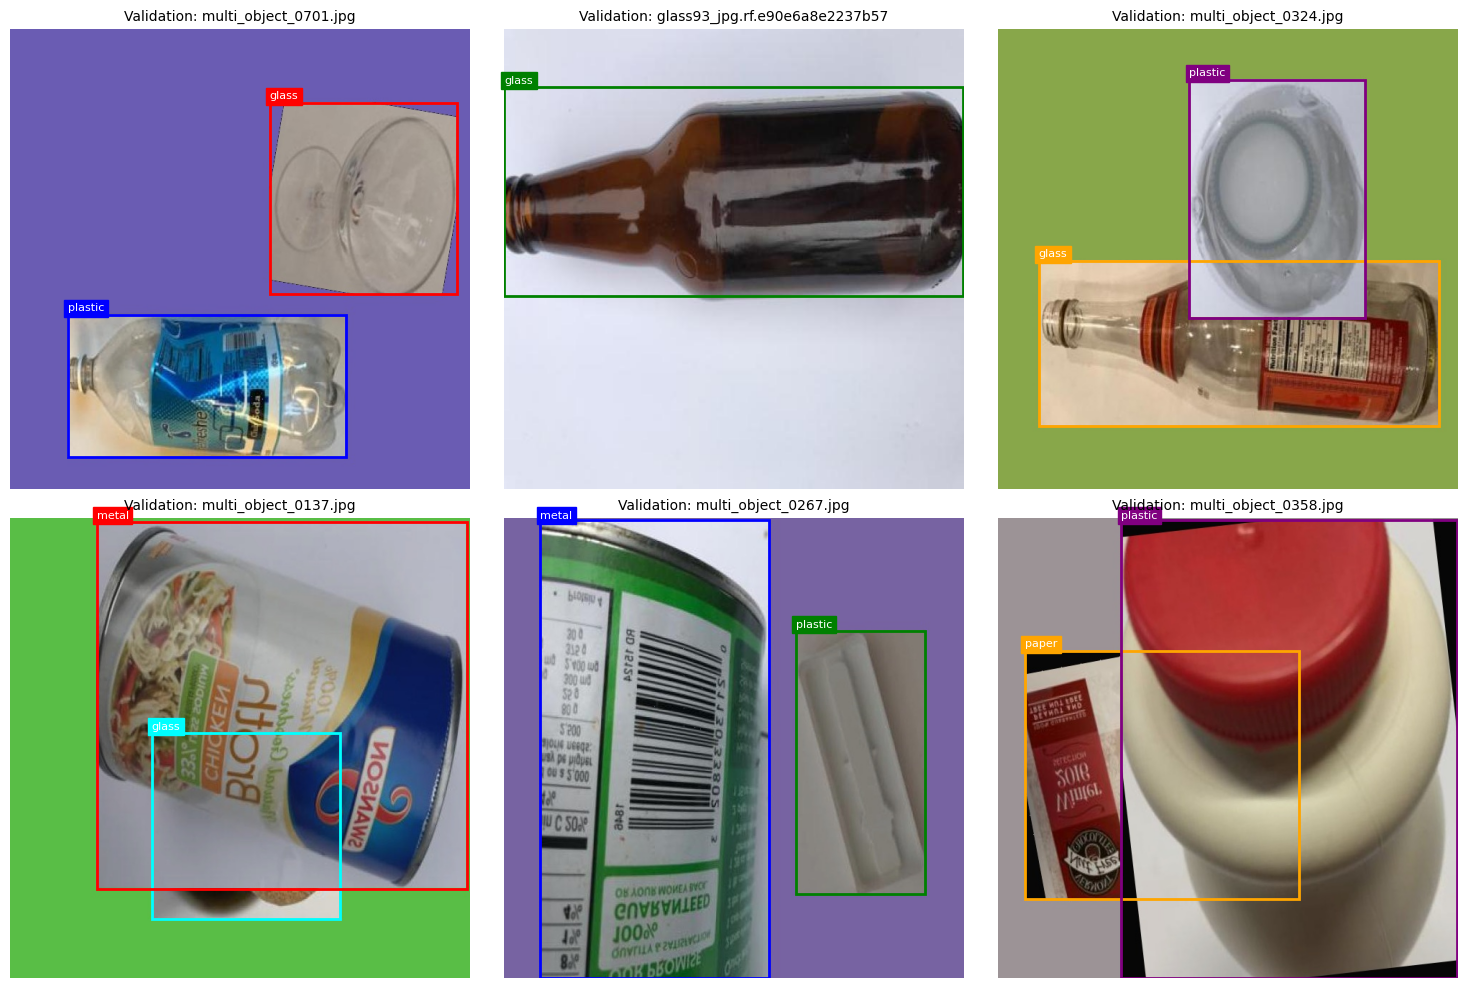

In [24]:
# Sample visuals from the validation split
print("=== VALIDATION SAMPLES ===")
visualize_samples(VALID_IMG_DIR, VALID_LABEL_DIR, CLASS_NAMES, num_samples=6, title="Validation")


=== TEST SAMPLES ===


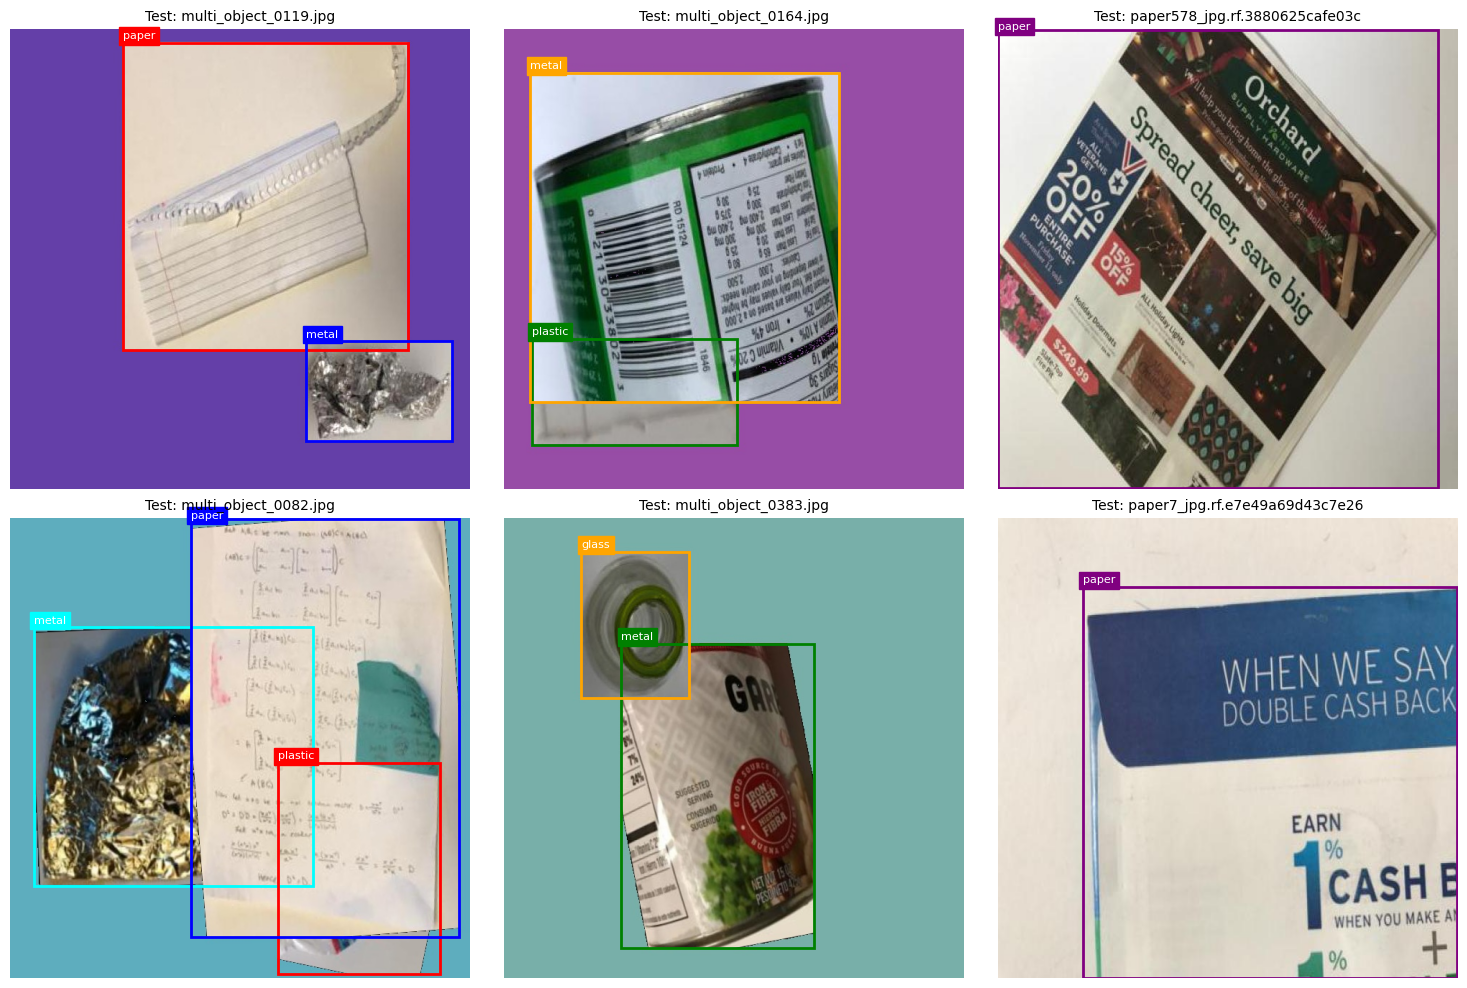

In [25]:
# Sample visuals from the test split
print("=== TEST SAMPLES ===")
visualize_samples(TEST_IMG_DIR, TEST_LABEL_DIR, CLASS_NAMES, num_samples=6, title="Test")


=== CLASS DISTRIBUTION ===


split  class_id class_name  count  percentage
0   train         2      paper   2085   25.897404
1   train         0      glass   1999   24.829214
2   train         3    plastic   2006   24.916159
3   train         1      metal   1961   24.357223
4   valid         1      metal    489   23.818802
5   valid         2      paper    528   25.718461
6   valid         0      glass    526   25.621042
7   valid         3    plastic    510   24.841695
8    test         1      metal    264   24.043716
9    test         2      paper    282   25.683060
10   test         3    plastic    276   25.136612
11   test         0      glass    276   25.136612

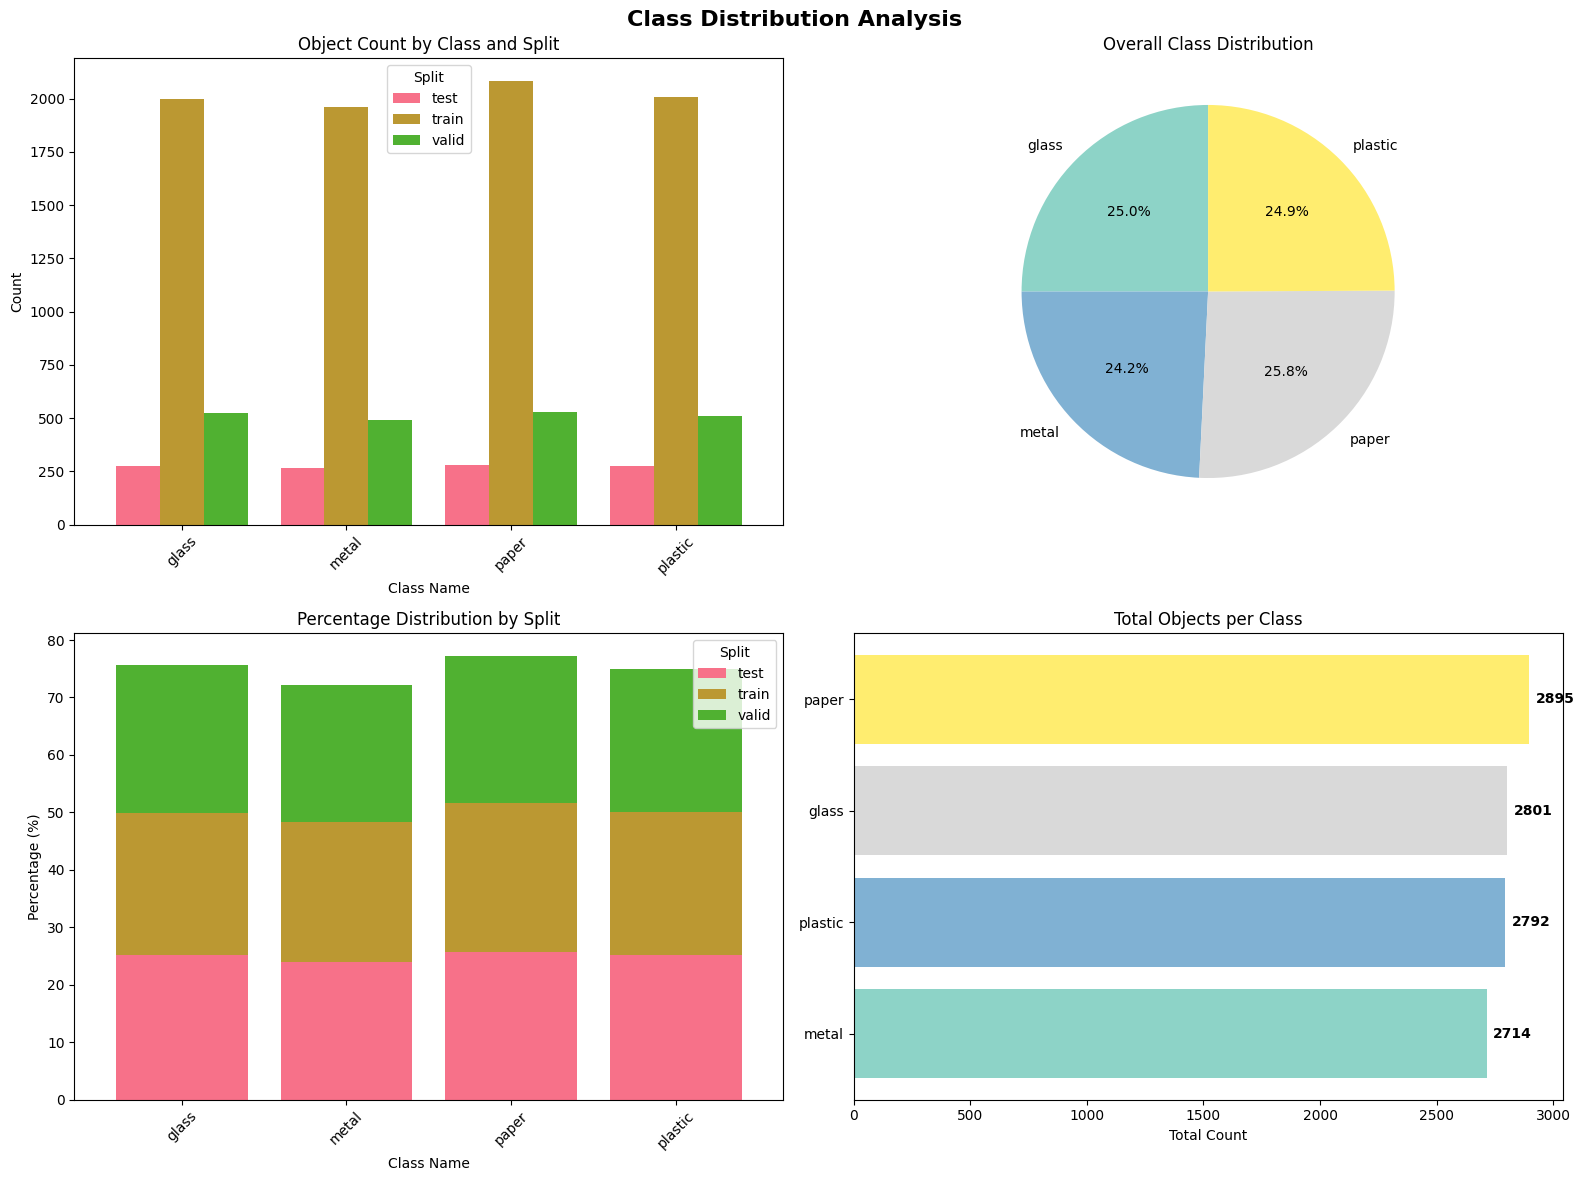


=== SUMMARY STATISTICS ===
Total objects: 11202
Number of classes: 4
Average objects per class: 2800.5

=== SPLIT DISTRIBUTION ===
Test: 1098 objects (9.8%)
Train: 8051 objects (71.9%)
Valid: 2053 objects (18.3%)


In [28]:
# Analyse class distribution across splits
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def analyse_class_distribution(label_dirs, class_names, set_names):
    records = []
    for label_dir, set_name in zip(label_dirs, set_names):
        counts = Counter()
        if label_dir.exists():
            for label_file in label_dir.glob('*.txt'):
                with open(label_file, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if parts:
                            class_id = int(float(parts[0]))
                            counts[class_id] += 1
        total = sum(counts.values())
        for class_id, count in counts.items():
            class_name = class_names[class_id] if class_id < len(class_names) else f"class_{class_id}"
            records.append({
                "split": set_name,
                "class_id": class_id,
                "class_name": class_name,
                "count": count,
                "percentage": (count / total * 100) if total else 0,
            })
    return pd.DataFrame(records)

label_dirs = [TRAIN_LABEL_DIR, VALID_LABEL_DIR, TEST_LABEL_DIR]
set_names = ["train", "valid", "test"]

print("=== CLASS DISTRIBUTION ===")
class_distribution = analyse_class_distribution(label_dirs, CLASS_NAMES, set_names)
display(class_distribution)

# Tạo các biểu đồ minh họa
if not class_distribution.empty:
    # Thiết lập style cho biểu đồ
    plt.style.use('default')
    sns.set_palette("husl")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Class Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Bar chart - Số lượng object theo từng class và split
    ax1 = axes[0, 0]
    pivot_counts = class_distribution.pivot(index='class_name', columns='split', values='count').fillna(0)
    pivot_counts.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_title('Object Count by Class and Split')
    ax1.set_xlabel('Class Name')
    ax1.set_ylabel('Count')
    ax1.legend(title='Split')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Pie chart - Tổng phân phối các class
    ax2 = axes[0, 1]
    total_by_class = class_distribution.groupby('class_name')['count'].sum()
    colors = plt.cm.Set3(np.linspace(0, 1, len(total_by_class)))
    wedges, texts, autotexts = ax2.pie(total_by_class.values, labels=total_by_class.index, 
                                       autopct='%1.1f%%', colors=colors, startangle=90)
    ax2.set_title('Overall Class Distribution')
    
    # 3. Stacked bar chart - Phần trăm theo split
    ax3 = axes[1, 0]
    pivot_pct = class_distribution.pivot(index='class_name', columns='split', values='percentage').fillna(0)
    pivot_pct.plot(kind='bar', stacked=True, ax=ax3, width=0.8)
    ax3.set_title('Percentage Distribution by Split')
    ax3.set_xlabel('Class Name')
    ax3.set_ylabel('Percentage (%)')
    ax3.legend(title='Split')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Horizontal bar chart - Tổng số lượng theo class
    ax4 = axes[1, 1]
    total_by_class_sorted = total_by_class.sort_values(ascending=True)
    bars = ax4.barh(range(len(total_by_class_sorted)), total_by_class_sorted.values, 
                    color=colors[:len(total_by_class_sorted)])
    ax4.set_yticks(range(len(total_by_class_sorted)))
    ax4.set_yticklabels(total_by_class_sorted.index)
    ax4.set_xlabel('Total Count')
    ax4.set_title('Total Objects per Class')
    
    # Thêm số liệu lên các bar
    for i, v in enumerate(total_by_class_sorted.values):
        ax4.text(v + max(total_by_class_sorted.values) * 0.01, i, str(int(v)), 
                va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Thống kê tổng quan
    print("\n=== SUMMARY STATISTICS ===")
    print(f"Total objects: {class_distribution['count'].sum()}")
    print(f"Number of classes: {len(class_distribution['class_name'].unique())}")
    print(f"Average objects per class: {class_distribution.groupby('class_name')['count'].sum().mean():.1f}")
    
    print("\n=== SPLIT DISTRIBUTION ===")
    split_totals = class_distribution.groupby('split')['count'].sum()
    total_objects = split_totals.sum()
    for split, count in split_totals.items():
        percentage = (count / total_objects * 100) if total_objects > 0 else 0
        print(f"{split.capitalize()}: {count} objects ({percentage:.1f}%)")
        
else:
    print("No data available for visualization")

In [29]:
model = YOLO('yolov8n.pt')  # load a pretrained model 

In [31]:
# Train with more robust defaults for Kaggle GPU runtime
train_results = model.train(
    #data set
    data=str(DATA_CONFIG),
    epochs=100,
    imgsz=640,
    batch=-1, # auto

    #device
    workers=4,
    device=0 if torch.cuda.is_available() else 'cpu',

    # Logging & saving
    name=RUN_NAME,
    project=str(RUNS_DIR),
    
    # Model settings
    pretrained=True,              # Sử dụng pretrained weights
    verbose=True,                 # Hiển thị chi tiết
    save=True,
    plots=True,
    cache=True,
    seed=SEED,

    # Optimization settings
    cos_lr=True,
    close_mosaic=10,
    lr0=0.005,
    lrf=0.05,
    momentum=0.937,
    weight_decay=5e-4,
    warmup_epochs=3,

    # Early stopping và validation
    patience=20,                  # Early stopping patience
    save_period=10,               # Lưu checkpoint mỗi n epochs
    val=True,                     # Validation trong quá trình training

    # Data augmentation parameters 
    hsv_h=0.015,                   # Hue augmentation 
    hsv_s=0.5,                    # Saturation augmentation
    hsv_v=0.3,                    # Value/brightness augmentation
    degrees=5.0,                  # Góc xoay tối đa 
    translate=0.1,               # Dịch chuyển ảnh
    scale=0.15,                    # Scale augmentation
    shear=0.0,                    # Shear 
    perspective=0.0,              # Perspective transformation
    flipud=0.0,                   # Rác không phụ thuộc hướng trái/phải.
    fliplr=0.5,                   # Flip horizontal 
    mosaic=0.5,                   # Mosaic augmentation
    mixup=0.05,                   # Mixup augmentation 
    copy_paste=0.0,               # Copy paste augmentation

    amp=True,                     # Automatic Mixed Precision (nếu hỗ trợ)
    fraction=1.0,                 # Sử dụng 100% dataset
    
)

best_model_path = Path(model.trainer.best_ckpt_path)
print(f"Best model saved at: {best_model_path}")


Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/input/waste2/data/data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.5, hsv_v=0.3, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.05, mask_ratio=4, max_det=300, mixup=0.05, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=garbage_detect2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspecti

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1159       2053      0.907      0.872       0.94      0.903
                 glass        490        526      0.885      0.844      0.935      0.886
                 metal        447        489      0.915       0.92      0.962      0.927
                 paper        484        528       0.91      0.953      0.959      0.932
               plastic        472        510      0.918      0.772      0.904      0.869
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/runs/garbage_detect2


AttributeError: 'DetectionTrainer' object has no attribute 'best_ckpt_path'

Training logs: /kaggle/working/runs/garbage_detect2/results.csv


epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
89     90  4760.88         0.28223         0.32973         0.97150   
90     91  4816.49         0.19662         0.16625         0.88349   
91     92  4868.62         0.19031         0.15815         0.88468   
92     93  4921.04         0.19097         0.16075         0.87967   
93     94  4973.29         0.18749         0.15714         0.88061   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
89               0.88049            0.89182           0.93323   
90               0.89396            0.88231           0.93451   
91               0.89837            0.87839           0.93330   
92               0.90419            0.87163           0.93365   
93               0.89663            0.88520           0.93341   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
89              0.89940       0.25443       0.42107       0.83485  0.000098   
90              0.90193       0.25293       0.42526       0.83498  0.000092   
91              0.90250       0.25338       0.43184       0.83348  0.000086   
92              0.90248       0.25231       0.43133       0.83547  0.000081   
93              0.90220       0.25470       0.42208       0.83834  0.000077   

      lr/pg1    lr/pg2  
89  0.000098  0.000098  
90  0.000092  0.000092  
91  0.000086  0.000086  
92  0.000081  0.000081  
93  0.000077  0.000077

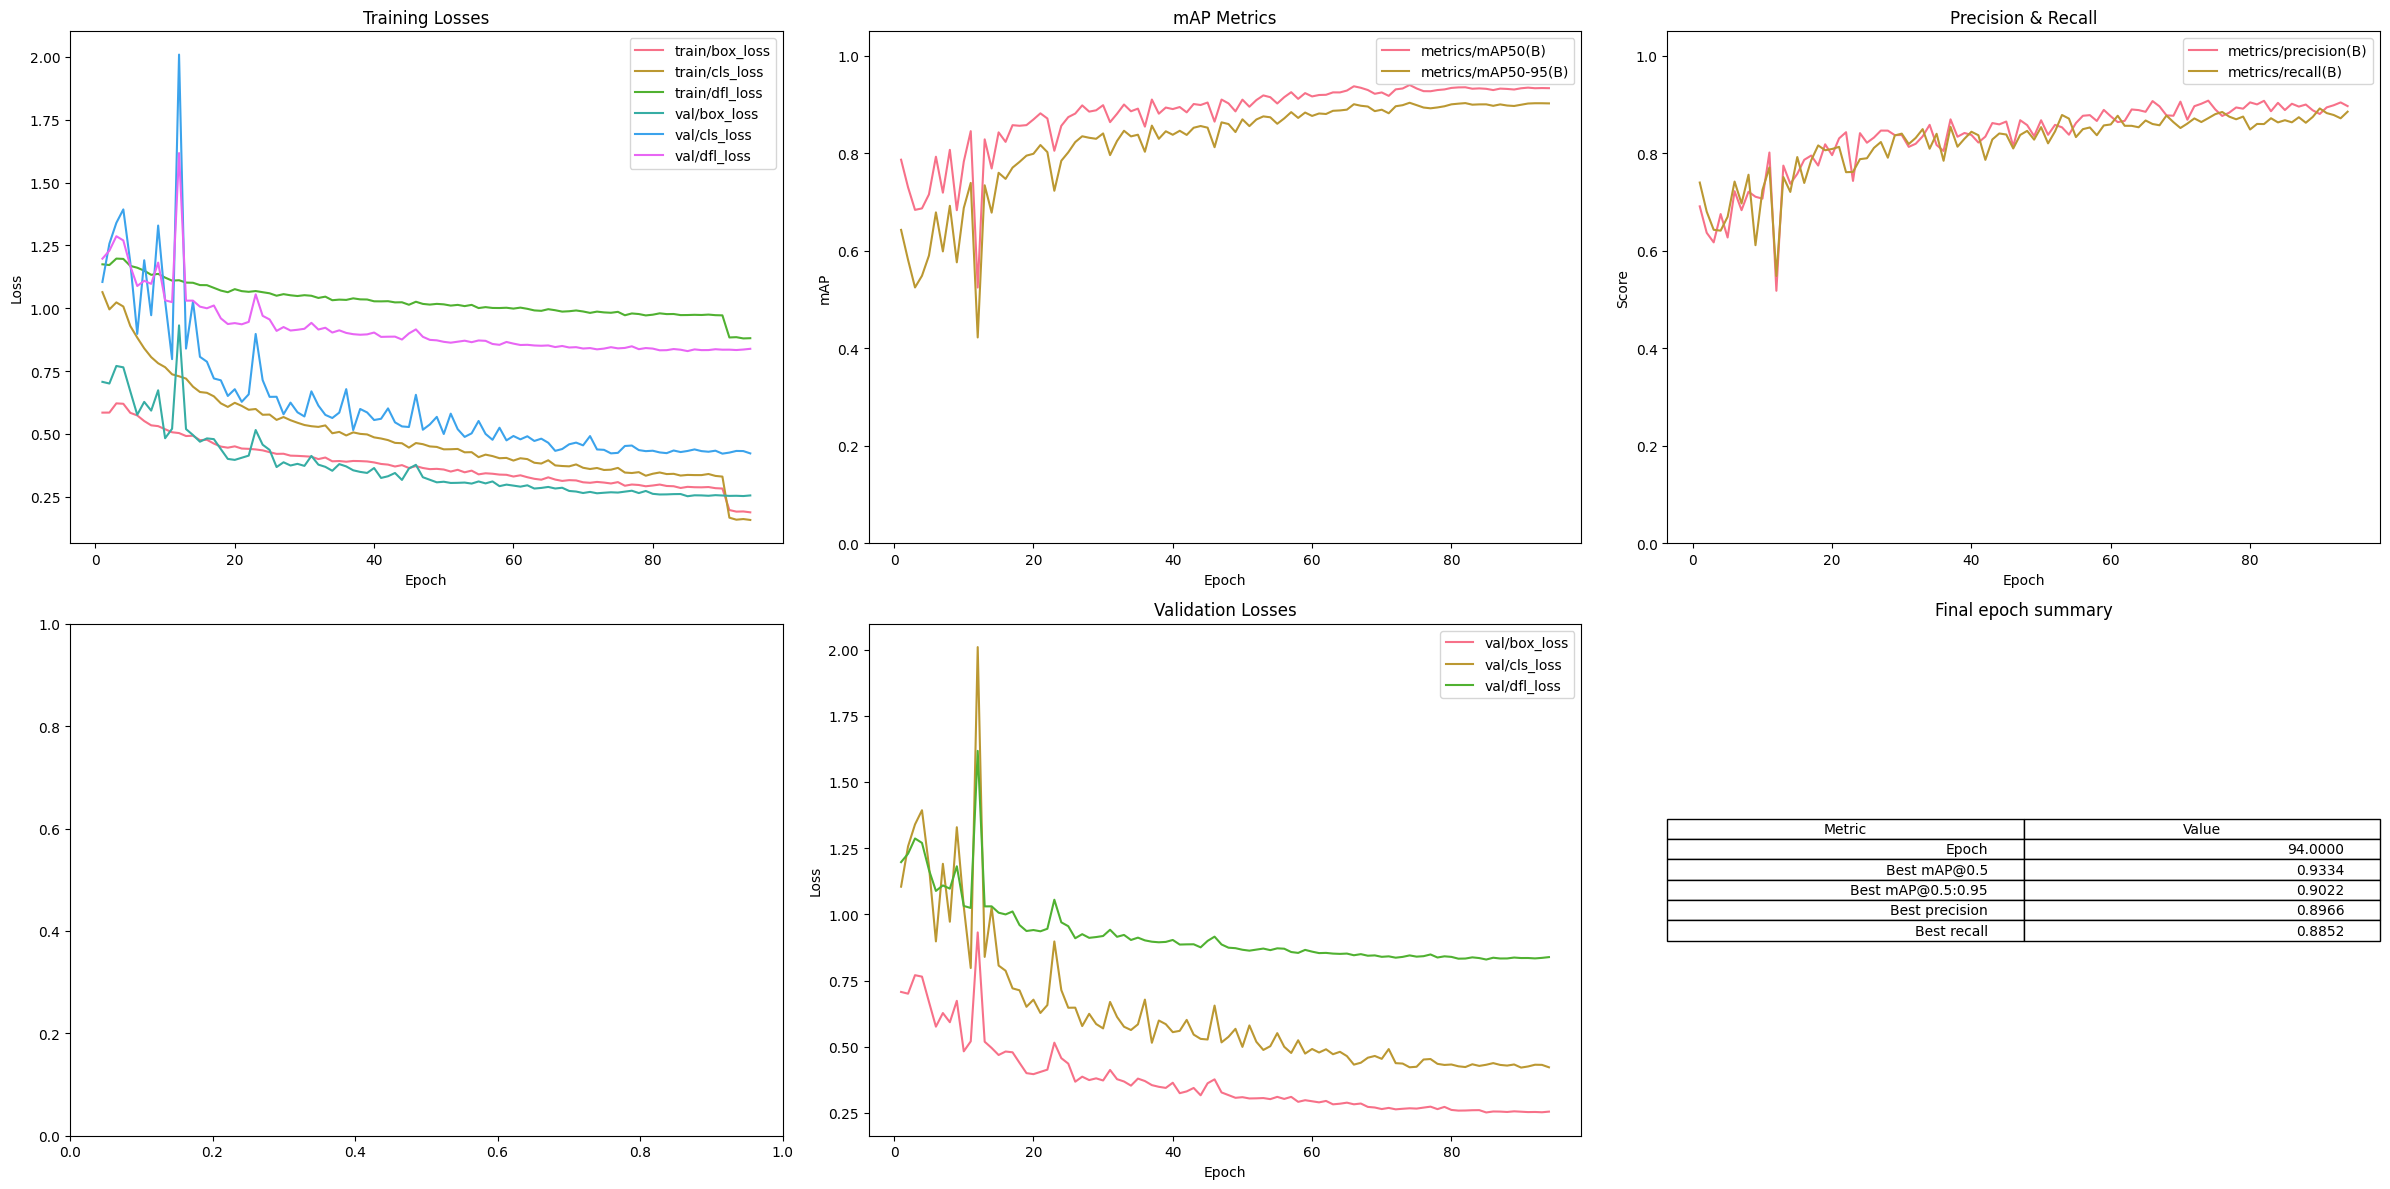

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

results_path = Path(model.trainer.save_dir) / "results.csv"
print(f"Training logs: {results_path}")

if not results_path.exists():
    print("results.csv not found. Run training first.")
else:
    results_df = pd.read_csv(results_path)
    display(results_df.tail())

    epochs = results_df['epoch'] if 'epoch' in results_df else results_df.index

    fig, axes = plt.subplots(2, 3, figsize=(24, 12))
    axes = np.array(axes)

    # Panel 1: Training and validation losses (box/cls/dfl)
    loss_cols = [
        ("train/box_loss", "train/box_loss"),
        ("train/cls_loss", "train/cls_loss"),
        ("train/dfl_loss", "train/dfl_loss"),
        ("val/box_loss", "val/box_loss"),
        ("val/cls_loss", "val/cls_loss"),
        ("val/dfl_loss", "val/dfl_loss"),
    ]
    for col, label in loss_cols:
        if col in results_df.columns:
            axes[0, 0].plot(epochs, results_df[col], label=label)
    axes[0, 0].set_title('Training Losses')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Panel 2: mAP metrics
    if 'metrics/mAP50(B)' in results_df.columns:
        axes[0, 1].plot(epochs, results_df['metrics/mAP50(B)'], label='metrics/mAP50(B)')
    if 'metrics/mAP50-95(B)' in results_df.columns:
        axes[0, 1].plot(epochs, results_df['metrics/mAP50-95(B)'], label='metrics/mAP50-95(B)')
    axes[0, 1].set_title('mAP Metrics')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('mAP')
    axes[0, 1].set_ylim(0, 1.05)
    axes[0, 1].legend()

    # Panel 3: Precision & recall
    if 'metrics/precision(B)' in results_df.columns:
        axes[0, 2].plot(epochs, results_df['metrics/precision(B)'], label='metrics/precision(B)')
    if 'metrics/recall(B)' in results_df.columns:
        axes[0, 2].plot(epochs, results_df['metrics/recall(B)'], label='metrics/recall(B)')
    axes[0, 2].set_title('Precision & Recall')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].set_ylim(0, 1.05)
    axes[0, 2].legend()

    # # Panel 4: Learning rate schedule
    # lr_cols = [c for c in results_df.columns if c.endswith('lr')]
    # if lr_cols:
    #     for lr_col in lr_cols:
    #         axes[1, 0].plot(epochs, results_df[lr_col], label=lr_col)
    #     axes[1, 0].set_title('Learning Rate')
    #     axes[1, 0].set_xlabel('Epoch')
    #     axes[1, 0].set_ylabel('Learning Rate')
    #     axes[1, 0].legend()
    # else:
    #     axes[1, 0].text(0.5, 0.5, 'No learning rate column in results.csv', ha='center', va='center')
    #     axes[1, 0].axis('off')

    # Panel 5: Validation losses only
    val_loss_cols = [
        ("val/box_loss", "val/box_loss"),
        ("val/cls_loss", "val/cls_loss"),
        ("val/dfl_loss", "val/dfl_loss"),
    ]
    has_val_loss = False
    for col, label in val_loss_cols:
        if col in results_df.columns:
            axes[1, 1].plot(epochs, results_df[col], label=label)
            has_val_loss = True
    if has_val_loss:
        axes[1, 1].set_title('Validation Losses')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()
    else:
        axes[1, 1].text(0.5, 0.5, 'Validation loss columns missing', ha='center', va='center')
        axes[1, 1].axis('off')

    # Panel 6: Summary statistics table
    axes[1, 2].axis('off')
    last_row = results_df.iloc[-1]
    metrics_summary = {
        'Epoch': int(last_row.get('epoch', len(results_df)-1)),
        'Best mAP@0.5': last_row.get('metrics/mAP50(B)', float('nan')),
        'Best mAP@0.5:0.95': last_row.get('metrics/mAP50-95(B)', float('nan')),
        'Best precision': last_row.get('metrics/precision(B)', float('nan')),
        'Best recall': last_row.get('metrics/recall(B)', float('nan')),
    }
    table_data = [[key, f"{value:.4f}" if isinstance(value, (int, float)) else value] for key, value in metrics_summary.items()]
    axes[1, 2].table(cellText=table_data, colLabels=['Metric', 'Value'], loc='center')
    axes[1, 2].set_title('Final epoch summary')

    plt.tight_layout()
    plt.show()


In [34]:
# Reload best weights for evaluation and inference
best_model_path = "/kaggle/working/runs/garbage_detect2/weights/best.pt"
best_model = YOLO(str(best_model_path))


Inference on: /kaggle/input/waste2/data/test/images/multi_object_0250.jpg

image 1/1 /kaggle/input/waste2/data/test/images/multi_object_0250.jpg: 640x640 1 glass, 1 paper, 1 plastic, 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


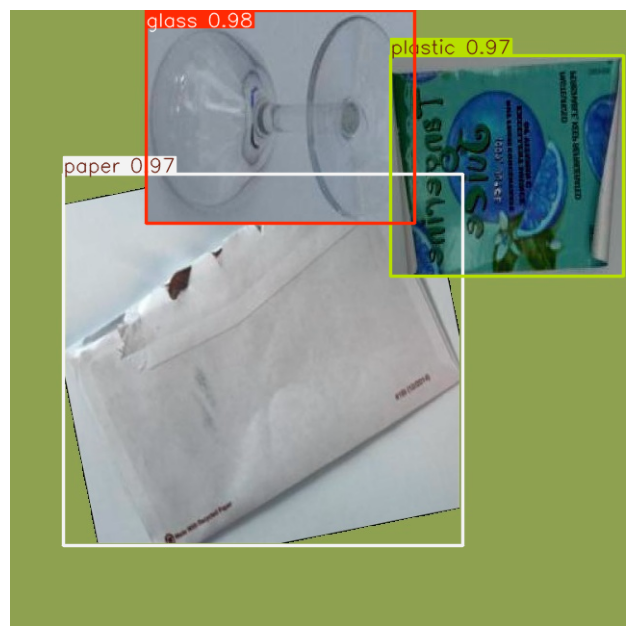

Detection 1: glass (0.977)
Detection 2: plastic (0.970)
Detection 3: paper (0.969)


In [35]:
# Inspect a single image prediction
if TEST_IMG_DIR.exists():
    sample_images = list(TEST_IMG_DIR.glob('*.jpg')) + list(TEST_IMG_DIR.glob('*.png'))
    image_path = str(random.choice(sample_images)) if sample_images else None
else:
    image_path = None

if image_path:
    print(f"Inference on: {image_path}")
    results = best_model(image_path, conf=0.2, iou=0.4)
    plotted = results[0].plot()
    plt.figure(figsize=(12, 8))
    plt.imshow(plotted)
    plt.axis('off')
    plt.show()

    boxes = results[0].boxes
    if boxes is not None and len(boxes) > 0:
        for i, box in enumerate(boxes):
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            class_name = CLASS_NAMES[class_id] if class_id < len(CLASS_NAMES) else f"class_{class_id}"
            print(f"Detection {i+1}: {class_name} ({confidence:.3f})")
else:
    print("No test images available for inference preview.")



image 1/1 /kaggle/input/waste2/data/test/images/multi_object_0124.jpg: 640x640 1 glass, 1 plastic, 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/waste2/data/test/images/plastic80_jpg.rf.8b5406c2859e862576e6a7df01f991a5.jpg: 640x640 1 plastic, 5.7ms
Speed: 1.4ms preprocess, 5.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/waste2/data/test/images/glass308_jpg.rf.a3557827abaed05e58eae11886770e25.jpg: 640x640 1 glass, 5.6ms
Speed: 1.3ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/waste2/data/test/images/multi_object_0373.jpg: 640x640 1 metal, 1 paper, 1 plastic, 6.2ms
Speed: 1.6ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/waste2/data/test/images/glass403_jpg.rf.68dcff175947284fe8c4c6bb97e02725.jpg: 640x640 1 glass, 5.8ms
Speed: 1.4ms p

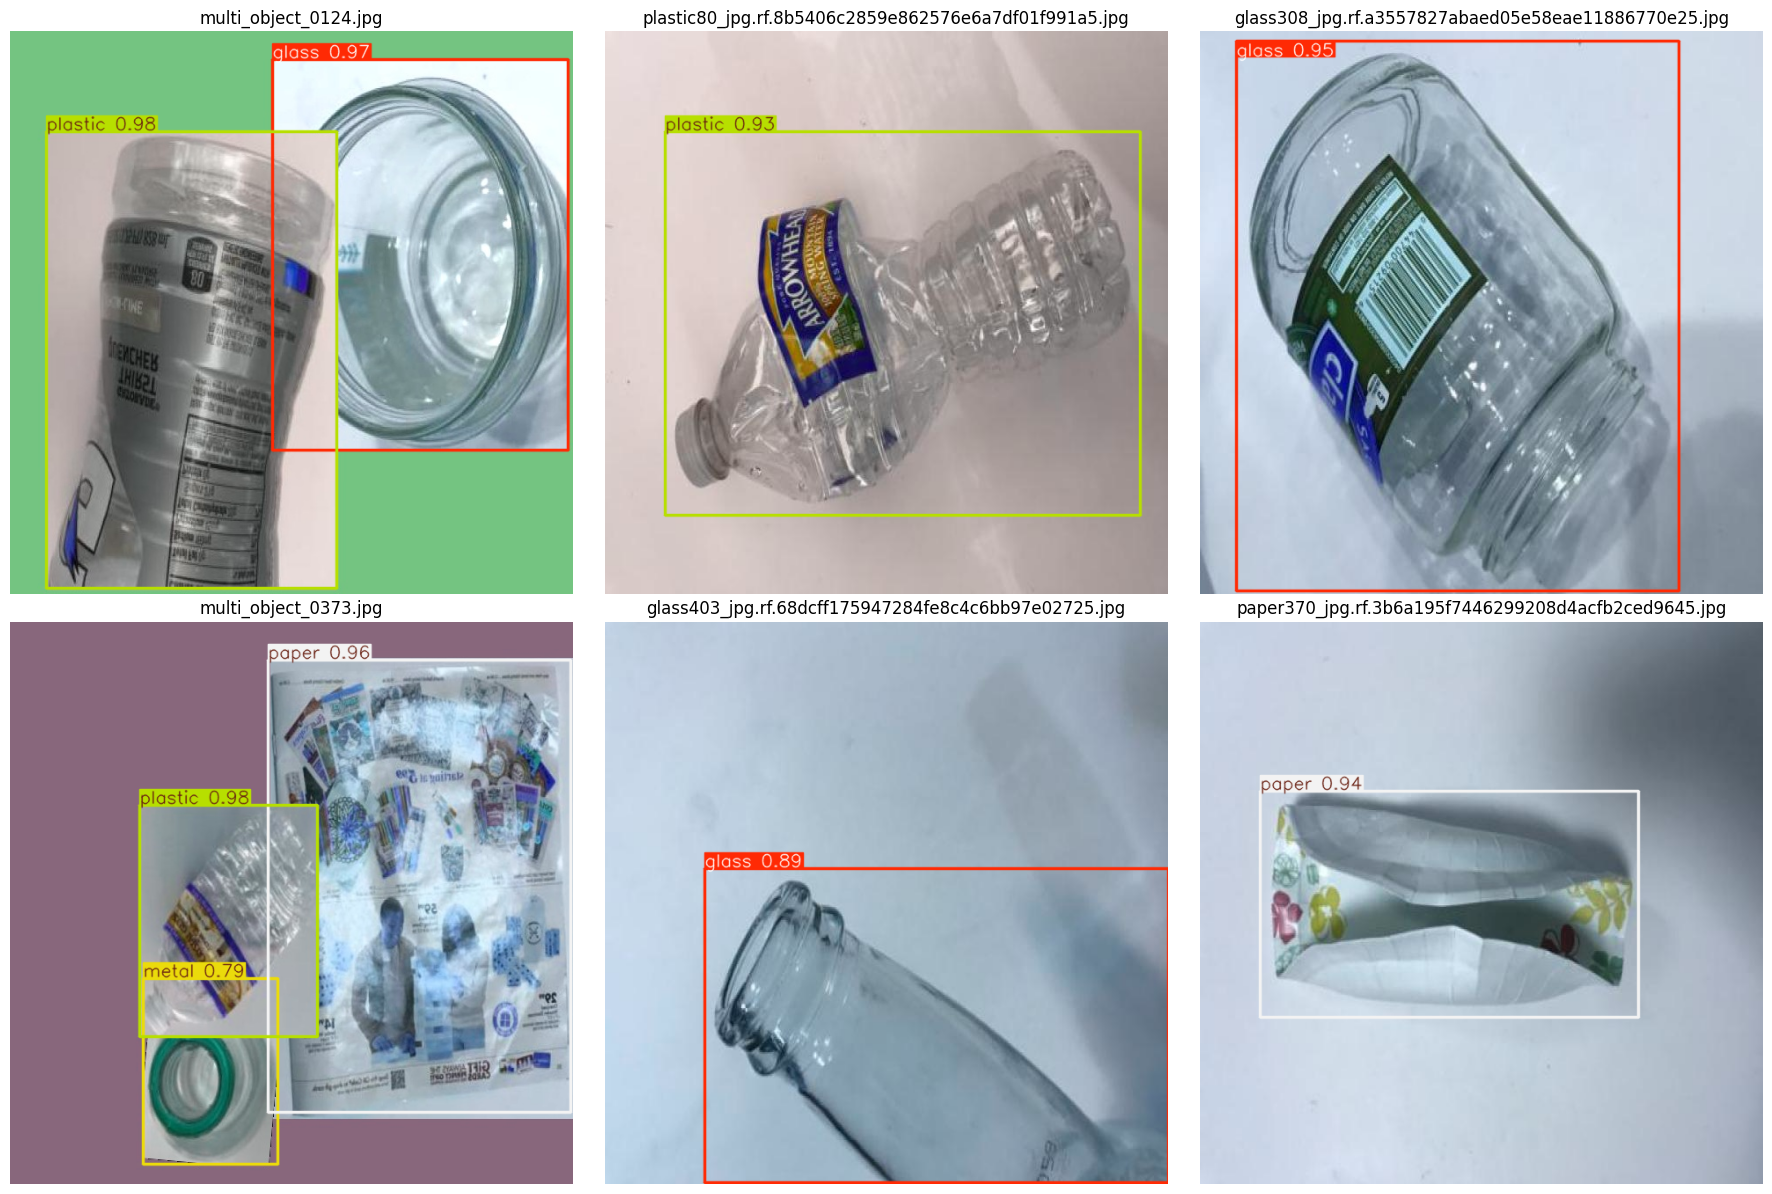

In [36]:
import math


def visualize_test_predictions(detector, image_dir: Path, num_images: int = 3, conf: float = 0.25, iou: float = 0.45):
    if not image_dir.exists():
        print(f"Image directory not found: {image_dir}")
        return

    image_paths = [p for p in image_dir.glob('*') if p.suffix.lower() in {'.jpg', '.jpeg', '.png'}]
    if not image_paths:
        print(f"No images found in {image_dir}")
        return

    selected = random.sample(image_paths, min(num_images, len(image_paths)))
    cols = min(3, len(selected))
    rows = math.ceil(len(selected) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for ax, image_path in zip(axes.flatten(), selected):
        results = detector(str(image_path), conf=conf, iou=iou)
        plotted = results[0].plot()
        ax.imshow(plotted)
        ax.set_title(image_path.name)
        ax.axis('off')

    # hide unused axes
    for ax in axes.flatten()[len(selected):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_test_predictions(best_model, TEST_IMG_DIR, num_images=6)


In [37]:
!zip -r working.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/yolov8n.pt (deflated 9%)
  adding: kaggle/working/yolo11n.pt (deflated 11%)
  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/garbage_detect/ (stored 0%)
  adding: kaggle/working/runs/garbage_detect/train_batch0.jpg (deflated 9%)
  adding: kaggle/working/runs/garbage_detect/train_batch1.jpg (deflated 8%)
  adding: kaggle/working/runs/garbage_detect/args.yaml (deflated 52%)
  adding: kaggle/working/runs/garbage_detect/weights/ (stored 0%)
  adding: kaggle/working/runs/garbage_detect/weights/last.pt (deflated 23%)
  adding: kaggle/working/runs/garbage_detect/weights/best.pt (deflated 23%)
  adding: kaggle/working/runs/garbage_detect/results.csv (deflated 50%)
  adding: kaggle/working/runs/garbage_detect/train_batch2.jpg (deflated 8%)
  adding: kaggle/working/runs/garbage_detect/labels.jpg (deflated 20%)
  adding: kaggle/working/runs/garbage_detect